In [1]:
%load_ext Cython

In [34]:
%%time
%%cython
## import usual stuff + cython
import numpy as np
import matplotlib.pyplot as plt
import math
from timeit import default_timer as timer

cimport cython
cimport numpy as np
from numpy cimport ndarray

## relaxation method to solve laplace's equation
cpdef np.float64_t[:,:] cy_solver(int grid, int maxiter):
    cdef int phi_bottom = 1
    cdef const double[:] x = np.linspace(0, 1, grid)
    cdef const double[:] y = x
    cdef double dx = x[1] - x[0]
    cdef double dy = dx
    cdef double A = 2.0/(dx*dx) + 2.0/(dy*dy)
    cdef double B = 1.0/(dx*dx)
    cdef double C = 1.0/(dy*dy)
    cdef np.float64_t[:,:] phi = np.zeros((grid,grid))
    # impose boundary conditions on bottom edge
    phi[:1, :] = phi_bottom
    # relaxation method
    cdef int t,i,j
    for t in range(maxiter):
        newphi = np.zeros((grid,grid))
        for i in range(1,grid-1):
            for j in range(1,grid-1):
                newphi[i,j] = (B*(phi[i+1,j] + phi[i-1,j]) + C*(phi[i,j+1] + phi[i,j-1]))/A
        for i in range(1,grid-1):
            for j in range(1,grid-1):
                phi[i,j] = newphi[i,j]
    ## plot solution
    colorinterpolation = 100
    colourMap = plt.cm.jet
    plt.contourf(x, y, phi, colorinterpolation, cmap=colourMap)
    plt.colorbar()
    plt.title('Grid = {}, Number of iterations = {}'.format(grid, maxiter))
    plt.show()
    return phi

## return a 2D array with values of numerical solution at x=0.25 for further comparison
# cpdef ndarray[:,:] cy_fill_array(int grids, int maxiters, phi_array, list grid_array, maxiter_array):
#     cdef int i,j
#     for i in range(grids):
#         for j in range(maxiters):
#             start = timer()
#             cy_phi = cy_solver(grid_array[i], maxiter_array[i,j])
#             end = timer()
#             time_taken = end-start
#             print('Time taken to solve grid = {}, iterations = {}: {:.3f}s'.format(grid_array[i], maxiter_array[i,j], time_taken))
#             cy_phi = np.asarray(cy_phi)
#             phi_array[i,j] = cy_phi[math.floor(grid_array[i]/4),:]
#     return phi_array

cpdef cy_fill_array(int grids, int maxiters, phi_array, time_array, list grid_array, maxiter_array):
    cdef int i,j
    for i in range(grids):
        for j in range(maxiters):
            start = timer()
            cy_phi = cy_solver(grid_array[i], maxiter_array[i,j])
            end = timer()
            time_taken = end-start
            print('Time taken to solve grid = {}, iterations = {}: {:.3f}s'.format(grid_array[i], maxiter_array[i,j], time_taken))
            cy_phi = np.asarray(cy_phi)
            phi_array[i,j] = cy_phi[math.floor(grid_array[i]/4),:]
            time_array[i,j] = time_taken
    return phi_array, time_array

## plot solution against x for 1 grid value and all iterations combinations on different figures
## e.g.: 2 grid values, 5 iterations will output 2 figures (5 graphs per figure)
cpdef void same_grid_different_iter_plot(int grids, int maxiters, ndarray[:,:] phi_array, list grid_array, maxiter_array):
    cdef int i
    for i in range(grids):
        plt.figure(figsize=(10,7))
        x_axis = np.linspace(0,1,grid_array[i])
        for j in range(maxiters):
            plt.plot(x_axis,phi_array[i,j], label = 'Iterations = {}'.format(maxiter_array[i,j]))
        plt.title('Grid = {}'.format(grid_array[i]))
        plt.legend()
        plt.show()
        
## return iteration numbers based on grid size and constant values
cpdef get_maxiter_array(list grid_array, list constant_array):
    cdef int grids = len(grid_array)
    cdef int constants = len(constant_array)
    cdef int i,j
    maxiter_array = np.zeros([grids, constants], dtype = np.int64)
    for i in range(grids):
        for j in range(constants):
            maxiter_array[i,j] = math.floor(constant_array[j]* (grid_array[i]**2))
    return maxiter_array

cpdef plot_time_taken(int grids, list grid_array, list constant_array, maxiter_array, time_array):
    cdef int i
    for i in range(grids):
        plt.figure()
        plt.plot(maxiter_array[i,:-1], time_array[i,:-1])
        x_ticks = constant_array
        plt.xticks(maxiter_array[i,:-1], x_ticks)
        plt.title('Grids = {}'.format(grid_array[i]))
        plt.ylabel('Time taken')
        plt.show()

## return avg_diff across all grid points
cpdef np.float64_t[:,:] get_avg_diff(grids, maxiters, phi_array):
    cdef int i,j
    avg_diff = np.zeros([grids, maxiters-1])
    for i in range(grids):
        for j in range(maxiters-1):
            avg_diff[i,j] = np.sum(np.abs(phi_array[i,phi_array.shape[1]-1]-phi_array[i,j]))/maxiters
    return avg_diff

## plot numerical error against analytical solution (log axis)
cpdef void plot_error_against_x(grid_array, constant_array, avg_diff, maxiter_array):
    cdef int i
    for i in range(len(grid_array)):
        plt.figure()
        x_axis = maxiter_array[i,:-1]
        y_axis = avg_diff[i]
        x_ticks = constant_array
        plt.xticks(x_axis, x_ticks)
        plt.semilogy(x_axis,y_axis)
        plt.title('Grid = {}'.format(grid_array[i]))
        plt.xlabel('Number of iterations (Constant)')
        plt.ylabel('Error')
        plt.show()

CPU times: user 1.27 s, sys: 40.6 ms, total: 1.31 s
Wall time: 7.06 s


In [41]:
%%time
## we can change the files of the following 2 arrays
## do not edit any other line of code
grid_array = [21,61,101]
constant_array = [1,1.25,1.5,1.75,2,2.5,3,4,5,10]
## solution converges at constant*grid^2 iterations.
## we will vary the constant values to test solution accuracy.
maxiter_array = get_maxiter_array(grid_array, constant_array)
grids = len(grid_array)
maxiters = maxiter_array.shape[1]

CPU times: user 36 µs, sys: 0 ns, total: 36 µs
Wall time: 38.9 µs


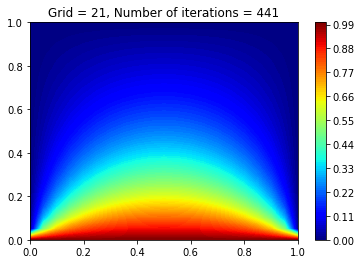

Time taken to solve grid = 21, iterations = 441: 0.278s


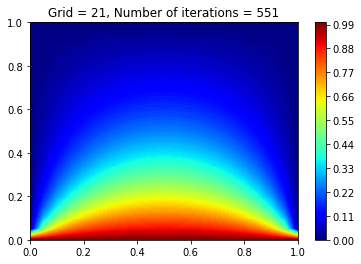

Time taken to solve grid = 21, iterations = 551: 0.322s


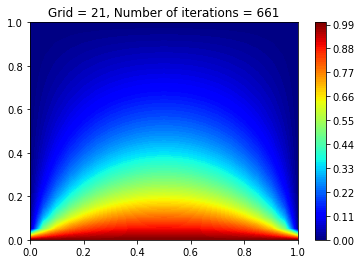

Time taken to solve grid = 21, iterations = 661: 0.392s


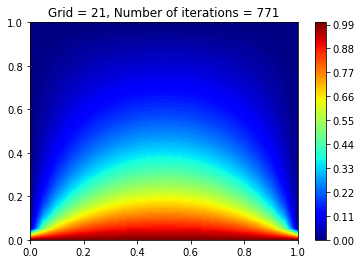

Time taken to solve grid = 21, iterations = 771: 0.323s


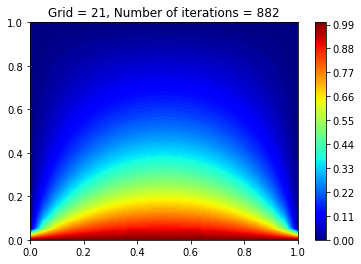

Time taken to solve grid = 21, iterations = 882: 0.319s


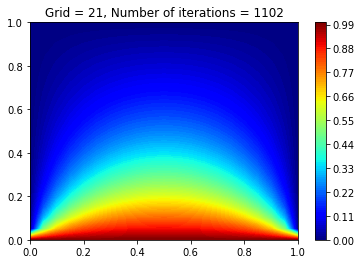

Time taken to solve grid = 21, iterations = 1102: 0.331s


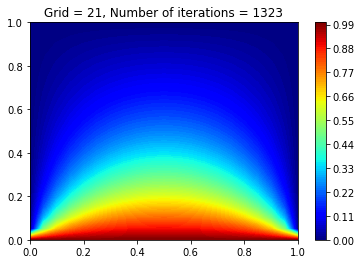

Time taken to solve grid = 21, iterations = 1323: 0.358s


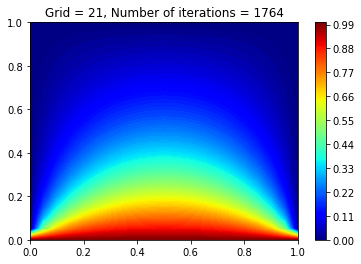

Time taken to solve grid = 21, iterations = 1764: 0.484s


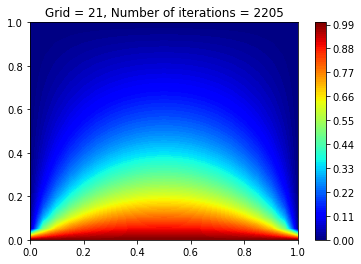

Time taken to solve grid = 21, iterations = 2205: 0.568s


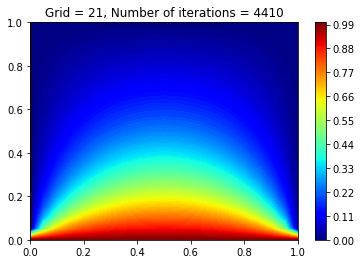

Time taken to solve grid = 21, iterations = 4410: 1.181s


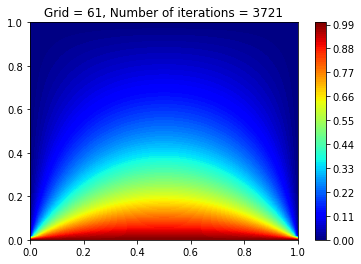

Time taken to solve grid = 61, iterations = 3721: 3.064s


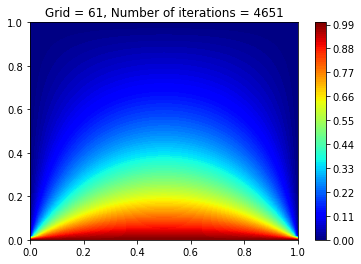

Time taken to solve grid = 61, iterations = 4651: 3.590s


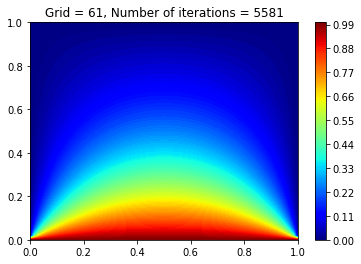

Time taken to solve grid = 61, iterations = 5581: 4.148s


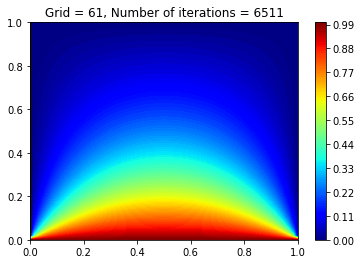

Time taken to solve grid = 61, iterations = 6511: 4.864s


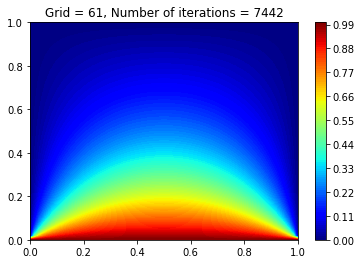

Time taken to solve grid = 61, iterations = 7442: 5.466s


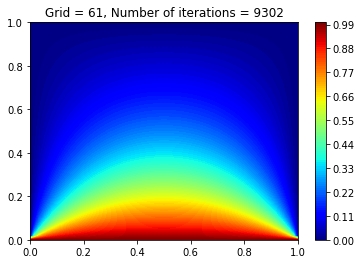

Time taken to solve grid = 61, iterations = 9302: 6.784s


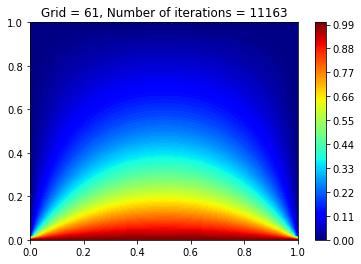

Time taken to solve grid = 61, iterations = 11163: 9.039s


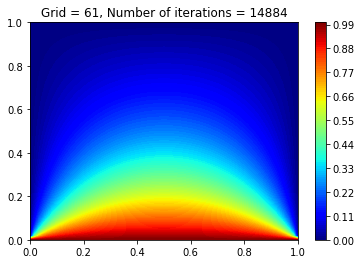

Time taken to solve grid = 61, iterations = 14884: 12.280s


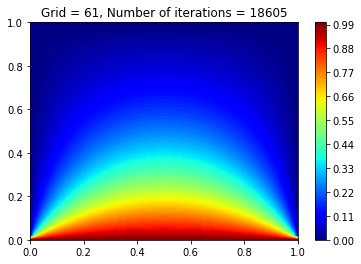

Time taken to solve grid = 61, iterations = 18605: 13.565s


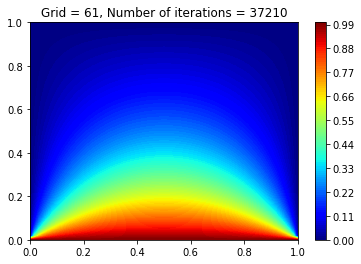

Time taken to solve grid = 61, iterations = 37210: 29.279s


In [ ]:
%%time
## create empty phi_array and empty time_array
phi_array = np.zeros([grids, maxiters] ,dtype=np.ndarray)
time_array = np.zeros([grids, maxiters])
## solve and plot phi_array given grid_array and maxiter_array
# phi_array = cy_fill_array(grids, maxiters, phi_array, grid_array, maxiter_array)
phi_array, time_array = cy_fill_array(grids, maxiters, phi_array, time_array, grid_array, maxiter_array)

In [ ]:
%%time
plot_time_taken(grids, grid_array, constant_array, maxiter_array, time_array)

In [ ]:
%%time
same_grid_different_iter_plot(grids, maxiters, phi_array, grid_array, maxiter_array)

In [ ]:
%%time
phi_array = np.asarray(phi_array)
avg_diff = get_avg_diff(grids, maxiters, phi_array)
plot_error_against_x(grid_array, constant_array, avg_diff, maxiter_array)

In [7]:
N = 201
x = np.linspace(0,1,N)
# print(x)
x[math.floor(N/4)]

0.25